In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import keras

In [2]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

170500096/170498071 [==============================] - 4s 0us/step


In [3]:
print('Training Data: %d %d*%d*%d' % x_train.shape)
print('Test Data: %d %d*%d*%d' % x_test.shape)

Training Data: 50000 32*32*3
Test Data: 10000 32*32*3


In [4]:
# input normalization
x_train_norm = x_train.astype('float32') / 255.0
x_test_norm = x_test.astype('float32') / 255.0

In [5]:
from keras.utils import to_categorical

# convert output to one-hot encoding
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

In [6]:
from tensorflow.keras.applications import EfficientNetB0

from keras.layers import Input
from keras.layers.experimental.preprocessing import Resizing
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Dense

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

inputs = Input(shape=(32, 32, 3))
resized_input = Resizing(IMG_SIZE, IMG_SIZE)(inputs)
pretrained_model = EfficientNetB0(include_top=False, input_tensor=resized_input, weights='imagenet')

# Freeze the pretrained weights
pretrained_model.trainable = False

# Rebuild top
x = GlobalAveragePooling2D(name='avg_pool')(pretrained_model.output)
x = BatchNormalization()(x)

top_dropout_rate = 0.05
x = Dropout(top_dropout_rate, name='top_dropout')(x)
x = Dense(256, activation='relu', name='hidden1')(x)
x = Dense(256, activation='relu', name='hidden2')(x)
outputs = Dense(10, activation='softmax', name='pred')(x)

model = keras.Model(inputs, outputs, name='EfficientNet')
model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
resizing (Resizing)             (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           resizing[0][0]                   
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
______________________

In [7]:
from keras.optimizers import Adam

# Compile
opt = Adam(learning_rate=1e-2)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [8]:
%%time

from keras.callbacks import EarlyStopping

# fit model
es = EarlyStopping(monitor='val_loss')

history = model.fit(x_train, y_train_oh, epochs=20, batch_size=256,
                    validation_data=(x_test, y_test_oh), verbose=2, callbacks=[es])

Epoch 1/20
196/196 - 139s - loss: 0.5712 - accuracy: 0.8189 - val_loss: 0.4796 - val_accuracy: 0.8596
Epoch 2/20
196/196 - 101s - loss: 0.3996 - accuracy: 0.8648 - val_loss: 0.3952 - val_accuracy: 0.8690
Epoch 3/20
196/196 - 101s - loss: 0.3687 - accuracy: 0.8769 - val_loss: 0.3917 - val_accuracy: 0.8720
Epoch 4/20
196/196 - 101s - loss: 0.3345 - accuracy: 0.8882 - val_loss: 0.3996 - val_accuracy: 0.8734
CPU times: user 1min 7s, sys: 7.45 s, total: 1min 14s
Wall time: 7min 21s


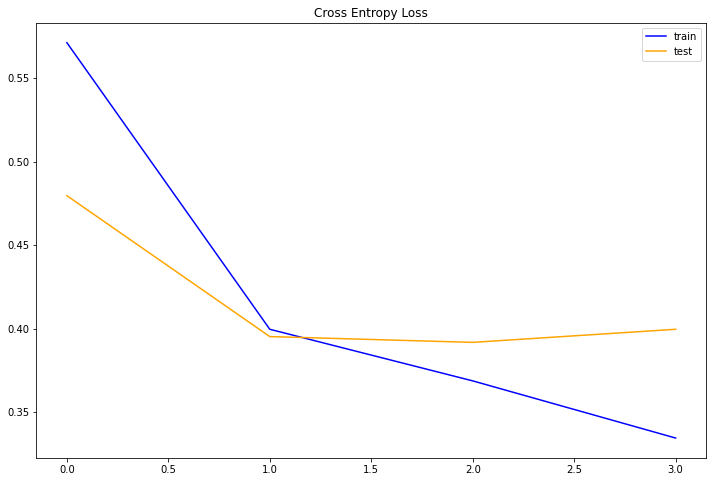

In [9]:
# plot loss
plt.figure(figsize=(12, 8))

plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.legend()

plt.savefig('loss_model_tl.jpg', orientation='landscape')
plt.show()

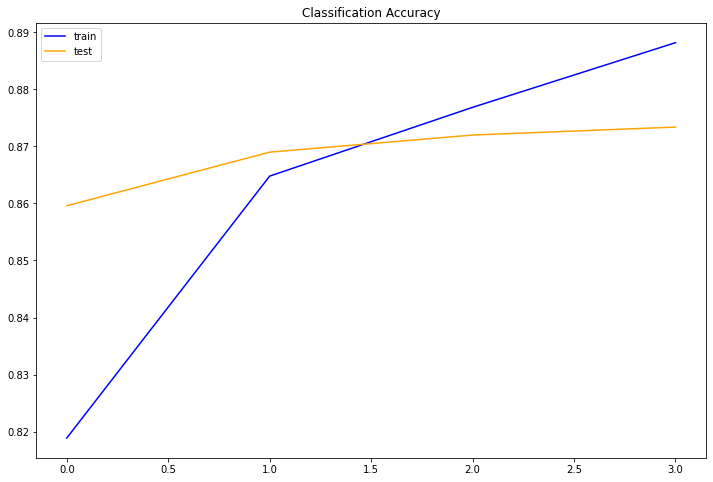

In [10]:
# plot accuracy
plt.figure(figsize=(12, 8))

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.legend()

plt.savefig('acc_model_tl.jpg', orientation='landscape')
plt.show()

In [11]:
y_pred = model.predict(x_test)

In [12]:
print(classification_report(y_test.reshape(-1), np.argmax(y_pred, axis=1), target_names=classes))

              precision    recall  f1-score   support

    airplane       0.93      0.84      0.88      1000
  automobile       0.96      0.92      0.94      1000
        bird       0.84      0.86      0.85      1000
         cat       0.81      0.73      0.76      1000
        deer       0.78      0.91      0.84      1000
         dog       0.81      0.86      0.83      1000
        frog       0.87      0.92      0.89      1000
       horse       0.98      0.80      0.88      1000
        ship       0.91      0.95      0.93      1000
       truck       0.89      0.95      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



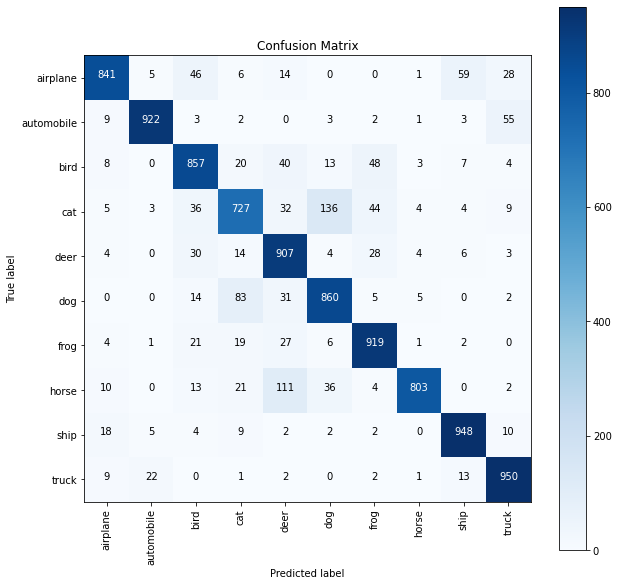

In [14]:
cm = confusion_matrix(y_test.reshape(-1), np.argmax(y_pred, axis=1))

plt.figure(figsize = (10, 10))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.savefig('cm_model_tl.jpg')
plt.show()

In [23]:
from numpy import expand_dims

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

import tensorflow as tf

In [60]:
img = load_img('cat.jpg')

# convert to numpy array
data = img_to_array(img)

# resize image to 32*32
data = tf.image.resize(data, (32, 32))

# expand dimension to one sample
samples = expand_dims(data, 0)

In [61]:
probs = model.predict(samples).flatten()

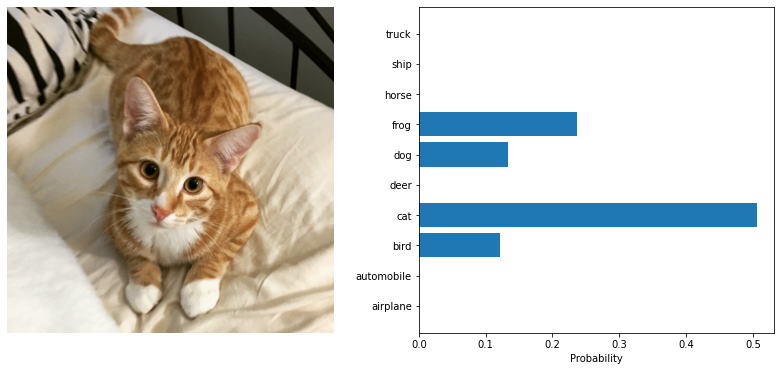

In [62]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.imshow(img)
plt.axis('off')

plt.subplot(122)
y_pos = range(len(probs))
plt.barh(y_pos, probs)
plt.yticks(y_pos, classes)
plt.xlabel('Probability')
plt.savefig('model_test.jpg')

plt.show()